In [ ]:
import os
import time
import sys
import urllib
import tarfile

import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50, VGG16
from keras.models import Model
from keras.layers import Input, Dense, MaxPooling2D, Layer, BatchNormalization, GlobalMaxPooling2D
from keras.metrics import Mean
from keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Notebooks/FaceNet/data

names-with-frequency.txt  pairsDevTrain.txt  peopleDevTest.txt	 people.txt
pairsDevTest.txt	  pairs.txt	     peopleDevTrain.txt  README.txt


In [ ]:
!mkdir data && cp /content/drive/MyDrive/Notebooks/FaceNet/data/* data/

In [ ]:
def download_and_uncompress_tarball(tarball_url, dataset_dir, uncompress=True):
    """Downloads the `tarball_url` and uncompresses it locally.
    Args:
    tarball_url: The URL of a tarball file.
    dataset_dir: The directory where the temporary files are stored.
    """
    filename = tarball_url.split('/')[-1]
    filepath = os.path.join(dataset_dir, filename)

    def _progress(count, block_size, total_size):
        sys.stdout.write('\r>> Downloading %s %.1f%%' % (
            filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(tarball_url, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')

    if uncompress:
        tarfile.open(filepath, 'r:gz').extractall(dataset_dir)

In [ ]:
database_url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'

download_folder = os.path.join('data')
download_path = os.path.join(download_folder, '/lfw-deepfunneled.tgz')

if not os.path.exists(download_folder):
    os.makedirs(download_folder)

if not os.path.exists(download_path):
    download_and_uncompress_tarball(database_url, download_folder)

>> Downloading lfw.tgz 100.0%
Successfully downloaded lfw.tgz 180566744 bytes.


In [ ]:
def load_image(path) :
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_txt_triplets(path) :
    triplets = [] # N x 3
    negatives = []
    base_path = os.path.join('data', 'lfw')

    with open(path, 'r') as f:
        N = int(f.readline().strip())
        for i in f :
            line = i.strip()
            split = line.split('	')

            if len(split) == 3 : #match
                #[name, img_value_1, img_value_2]
                anchor = os.path.join(base_path, split[0], f'{split[0]}_{split[1].zfill(4)}.jpg')
                positive = os.path.join(base_path, split[0], f'{split[0]}_{split[2].zfill(4)}.jpg')
                triplets.append([anchor, positive])

            else : #mismatch
                #[name_1, img_value_1, name_2, img_value_2]
                neg_pair_1 = os.path.join(base_path, split[0], f'{split[0]}_{split[1].zfill(4)}.jpg')
                neg_pair_2 = os.path.join(base_path, split[2], f'{split[2]}_{split[3].zfill(4)}.jpg')
                negatives.append(np.random.choice([neg_pair_1, neg_pair_2]))


    triplets = np.array(triplets) # N x 2
    negatives = np.array(negatives) # N
    triplets = np.hstack((triplets, negatives.reshape(-1, 1)))

    return triplets


def get_name(path) :
    # Using os.path.split() to split the path
    head, tail = os.path.split(path)
    # Using os.path.split() again to split the head into directory and file parts
    directory, filename = os.path.split(head)

    return filename

In [ ]:
image_files = tf.data.Dataset.list_files(os.path.join('data', 'lfw', '*', '*.jpg'), shuffle=False)
image_files

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
it = image_files.as_numpy_iterator()
it

In [ ]:
path = it.next()
path

b'data/lfw/AJ_Cook/AJ_Cook_0001.jpg'

In [ ]:
img = load_image(path)
img

<tf.Tensor: shape=(250, 250, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [199, 168, 124],
        [199, 168, 124],
        [199, 168, 124]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [201, 170, 126],
        [200, 169, 125],
        [200, 169, 125]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [201, 170, 12

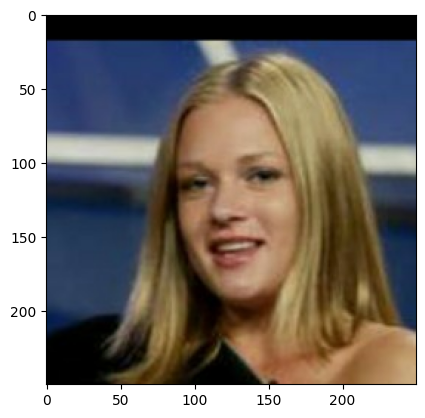

In [ ]:
plt.imshow(img)

In [ ]:
txt_triplets = load_txt_triplets(os.path.join('data', 'pairsDevTrain.txt'))#lists of tuples - anchor, positive, negative
txt_triplets.shape

(1100, 3)

In [ ]:
def show_pairs(txt_pairs, figsize=(10, 6)) :

    N = len(txt_pairs)
    fig = plt.figure(figsize=figsize)
    fig, axs = plt.subplots(ncols=3, nrows=N)
    for idx_row, ax_row in enumerate(axs):
        for idx_col, ax_col in enumerate(ax_row) :
            path = txt_pairs[idx_row, idx_col]
            ax_col.imshow(load_image(path))
            ax_col.axis('off')
            ax_col.set_title(get_name(path))

    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.05)

<Figure size 500x200 with 0 Axes>

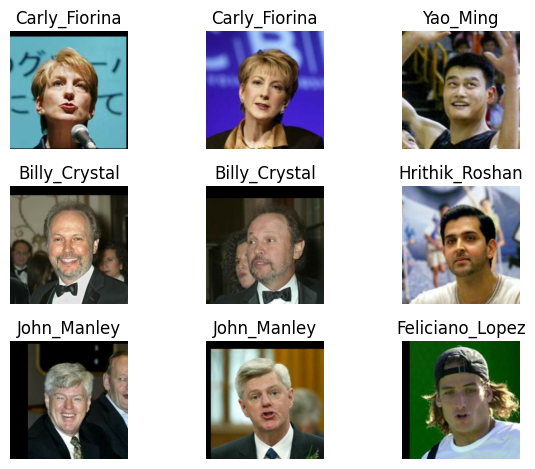

In [ ]:
N = 3 #how many pairs of match/mis-match you want to see
random_indices = np.random.choice(len(txt_triplets), N)
random_txt_triplets = txt_triplets[random_indices]

show_pairs(random_txt_triplets, (5, 2))

In [ ]:
data = tf.data.Dataset.from_tensor_slices(txt_triplets)

In [ ]:
it = data.as_numpy_iterator()
display(it.next(), it.next())

array([b'data/lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg',
       b'data/lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg',
       b'data/lfw/AJ_Cook/AJ_Cook_0001.jpg'], dtype=object)

array([b'data/lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg',
       b'data/lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg',
       b'data/lfw/Frank_Solich/Frank_Solich_0005.jpg'], dtype=object)

In [ ]:
TARGET_SIZE = 160, 160
PADDING = 20

def preprocess_image(path):
    image = load_image(path)

    image = tf.image.convert_image_dtype(image, tf.float64) #normalizes image
    #image = image / 255
    image = tf.image.resize(image, TARGET_SIZE)
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    Inputs: a tuple of filenames
    Output: a tuple of preprocessed images
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

In [ ]:
preprocessed_img = preprocess_image(path)
preprocessed_img

<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00

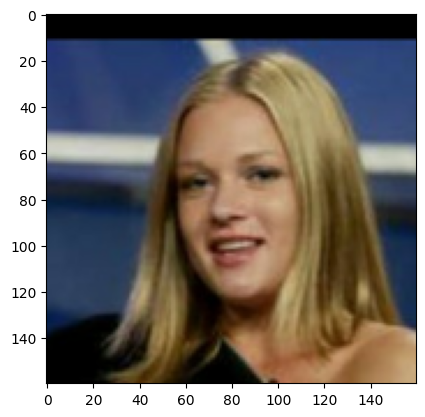

In [ ]:
plt.imshow(preprocessed_img)

In [ ]:
preprocessed_img.shape

TensorShape([160, 160, 3])

In [ ]:
def augment_image(image):
    #random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)
    return image


def augment_triplet_images(anchor, positive, negative):
    """
    Inputs: a tuple of images
    Output: a tuple of augmented images
    """

    return (
        augment_image(anchor),
        augment_image(positive),
        augment_image(negative)
    )

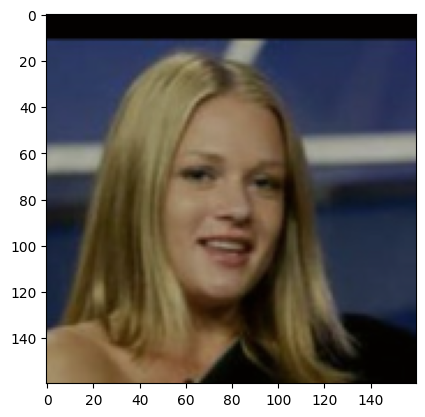

In [ ]:
plt.imshow(augment_image(preprocessed_img))

In [ ]:
BATCH_SIZE = 32
PREFETCH_SIZE = 32

In [ ]:
training_txt_triplets = load_txt_triplets(os.path.join('data', 'pairsDevTrain.txt'))#lists of tuples - anchor, positive, negative
training_data = tf.data.Dataset.from_tensor_slices(training_txt_triplets)
training_data = training_data.map(lambda x: preprocess_triplets(x[0], x[1], x[2]))
training_data = training_data.map(lambda a, p, n: (augment_triplet_images(a, p, n)))
training_data = training_data.repeat(10)
training_data = training_data.shuffle(1000)
training_data = training_data.batch(BATCH_SIZE)
training_data = training_data.prefetch(PREFETCH_SIZE)
print(f'Lenth of training data {len(training_data)}')

Lenth of training data 344


In [ ]:
validation_txt_triplets = load_txt_triplets(os.path.join('data', 'pairsDevTest.txt'))#lists of tuples - anchor, positive, negative
validation_data = tf.data.Dataset.from_tensor_slices(validation_txt_triplets)
validation_data = validation_data.map(lambda x: preprocess_triplets(x[0], x[1], x[2]))
validation_data = validation_data.map(lambda a, p, n: (augment_triplet_images(a, p, n)))
validation_data = validation_data.shuffle(1000)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(PREFETCH_SIZE)
print(f'Lenth of validation data {len(validation_data)}')

Lenth of validation data 16


In [ ]:
# inception_v3 = VGG16(weights='imagenet',
#                            input_shape = TARGET_SIZE + (3,),
#                            include_top=False)

In [ ]:
inception_v3 = ResNet50(weights='imagenet',
                           input_shape = TARGET_SIZE + (3,),
                           include_top=False)

In [ ]:
# inception_v3 = InceptionV3(weights='imagenet',
#                            input_shape = TARGET_SIZE + (3,),
#                            include_top=False)

In [ ]:
for layer in inception_v3.layers:
    layer.trainable = False

In [ ]:
inception_v3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
@tf.keras.saving.register_keras_serializable()
class L1Similarity(Layer):
    def __init__(self) :
        super().__init__()

    def call(self, anchor, positive, negative) :
        d1 = tf.maths.abs(anchor - positive)
        d2 = tf.maths.abs(anchor - negative)
        return (d1, d2)

    def get_config(self):
        config = {}
        base_config = super(L1Similarity, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

@tf.keras.saving.register_keras_serializable()
class L2Similarity(Layer):
    def __init__(self, **kwargs) :
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative) :
        anchor = tf.nn.l2_normalize(anchor, axis=-1)
        positive = tf.nn.l2_normalize(positive, axis=-1)
        negative = tf.nn.l2_normalize(negative, axis=-1)

        d1 = tf.reduce_sum(tf.square(anchor - positive), axis = -1)
        d2 = tf.reduce_sum(tf.square(anchor - negative), axis = -1)

        # Normalization
        # d1 = d1 / tf.norm(d1)
        # d2 = d2 / tf.norm(d2)
        return (d1, d2)

    def get_config(self):
        return super(L2Similarity, self).get_config()

In [ ]:
input_ = Input(shape=TARGET_SIZE + (3,))
x = inception_v3 (input_)
x = GlobalMaxPooling2D() (x)
x = Dense(1024, activation='relu') (x)
x = BatchNormalization() (x)
x = Dense(512, activation='relu') (x)
x = BatchNormalization() (x)
x = Dense(128) (x)
embedding_model = Model(inputs = input_,
                                 outputs = x, name='embedding')
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               52

In [ ]:
#anchor image input in the network
anchor = Input(name='anchor', shape = TARGET_SIZE + (3,))

#positive image in the network
positive = Input(name='positive', shape = TARGET_SIZE + (3,))

#negative image in the network
negative = Input(name='negative', shape = TARGET_SIZE + (3,))

similarity_layer = L2Similarity()
similarity_layer.__name = 'Similarity'
similarity_output = similarity_layer(
    embedding_model(anchor),
    embedding_model(positive),
    embedding_model(negative)
)

siamese_model = Model(inputs = [anchor, positive, negative], outputs = similarity_output, name='SiameseModel')
siamese_model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 128)                  2628249   ['anchor[0][0]',              
                                                          6          'positive[0][0]', 

In [ ]:
for batch in validation_data:
    anchor_images, positive_images, negative_images = batch
    # Pass the tensors to the siamese_model
    print(siamese_model((anchor_images, positive_images, negative_images)))
    break

(<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.03592039, 0.02085871, 0.04070719, 0.04006123, 0.00498589,
       0.02659697, 0.01272498, 0.01823643, 0.01789372, 0.02115189,
       0.02647663, 0.00890348, 0.03810495, 0.08223465, 0.07626021,
       0.03514382, 0.00813931, 0.06199992, 0.10802962, 0.04148521,
       0.03385269, 0.01026378, 0.00902439, 0.05574471, 0.02468343,
       0.07396163, 0.02808011, 0.01112218, 0.00782577, 0.04594086,
       0.02361548, 0.00364033], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.02177392, 0.01747592, 0.02768208, 0.03817386, 0.00687737,
       0.03401123, 0.01848976, 0.00142787, 0.03810163, 0.01803917,
       0.0319999 , 0.08735837, 0.03421242, 0.00806675, 0.10333033,
       0.03219327, 0.01804957, 0.04189719, 0.01962239, 0.03109992,
       0.02790426, 0.00654205, 0.00834494, 0.0078459 , 0.0091688 ,
       0.11032765, 0.04992989, 0.00223057, 0.00834161, 0.05053978,
       0.04641166, 0.00443892], dtype=float32)>)


In [ ]:
class FaceNet(Model) :
    def __init__(self, siamese_model, alpha = 0.5, **kwargs):
        super(FaceNet, self).__init__(**kwargs)

        self.siamese_model = siamese_model
        self.alpha = alpha
        self.threshold = tf.Variable(0.0, trainable=False, name='threshold')

        self.loss_tracker = Mean(name="loss")
        self.build(siamese_model.input_shape)


    def call(self, inputs, **kwargs):
        return self.siamese_model(inputs, **kwargs)

    # customize the training process: providing our own training step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # call custom loss function

            d1, d2 = self.siamese_model(data, training=True)
            threshold = self.compute_threshold(d1, d2)
            loss = self.triplet_loss(d1, d2)
            VAL = self.validation_rate(d1, d2)
            FAR = self.false_accept_rate(d1, d2)

        # Compute gradients
        trainable_vars = self.siamese_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the threshold
        self.threshold.assign(threshold)

        # Update our training loss metric
        self.loss_tracker.update_state(loss)

        return {"avg_loss": self.loss_tracker.result(), "loss":loss, "VAL":VAL, "FAR":FAR}

    # providing our own evaluation step
    def test_step(self, data):

        d1, d2 = self.siamese_model(data)
        loss = self.triplet_loss(d1, d2)
        VAL = self.validation_rate(d1, d2)
        FAR = self.false_accept_rate(d1, d2)

        # Update our test loss metric
        self.loss_tracker.update_state(loss)

        return {"avg_loss": self.loss_tracker.result(), "loss":loss, "VAL":VAL, "FAR":FAR}

    # custom loss function
    def triplet_loss(self, d1, d2):
        # compute the triplet loss
        loss = tf.maximum(d1 - d2 + self.alpha, 0)
        loss = tf.reduce_sum(loss)

        return loss

    def validation_rate(self, d1, d2):
        # Compare the distances and count correct predictions
        true_accepts = tf.reduce_sum(tf.cast(d1 <= self.threshold, tf.float32))
        size = tf.cast(tf.shape(d1)[0], tf.float32)
        VAL = true_accepts / size
        return VAL

    def false_accept_rate(self, d1, d2):
        # Compare the distances and count incorrect predictions
        false_accepts = tf.reduce_sum(tf.cast(d2 <= self.threshold, tf.float32))
        size = tf.cast(tf.shape(d2)[0], tf.float32)
        FAR = false_accepts / size
        return FAR

    def compute_threshold(self, d1, d2):
        mean_distance = tf.reduce_mean(tf.concat([d1, d2], axis=0))
        std_distance = tf.math.reduce_std(tf.concat([d1, d2], axis=0))

        # Set threshold as a multiple of the standard deviation away from the mean
        threshold = mean_distance * (std_distance)
        return threshold

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]

    def get_config(self):
        config = {
            "siamese_model": self.siamese_model,
            "alpha": self.alpha,
            # "threshold" : self.threshold
        }
        base_config = super(FaceNet, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [ ]:
d1, d2 = siamese_model((anchor_images, positive_images, negative_images))

In [ ]:
#callbacks

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1e-2),
    (2, 1e-3),
    (5, 1e-4),
    (10, 1e-5),
]

class CustomLearningRateScheduler(Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch+1}: Learning rate is {scheduled_lr:.7f}.")


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [ ]:
mcp_save = ModelCheckpoint('model.tf',
                           monitor='val_loss',
                          mode='min')

In [ ]:
early_stopping_callback = EarlyStopping(patience=10,monitor='val_loss',)

In [ ]:
face_net_model = FaceNet(siamese_model, name='FaceNet')
_ = face_net_model(siamese_model.inputs)
face_net_model.summary()

Model: "FaceNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SiameseModel (Functional)   ((None,),                 26282496  
                              (None,))                           
                                                                 
Total params: 26282499 (100.26 MB)
Trainable params: 2691712 (10.27 MB)
Non-trainable params: 23590787 (89.99 MB)
_________________________________________________________________


In [ ]:
batches_per_epoch = len(training_data)
lr_decay = (1./0.75 - 1) / batches_per_epoch
lr_decay # the drop in lr rate after each epoch
face_net_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=lr_decay), weighted_metrics=[])

In [ ]:
lr_decay

0.0009689922480620153

In [ ]:
start = time.time()

hist = face_net_model.fit(
    training_data,
    validation_data=validation_data,
    epochs=50,
    workers=8,
    callbacks=[
       # CustomLearningRateScheduler(lr_schedule),
        mcp_save,
        early_stopping_callback
    ],)

stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/50
344/344 [==============================] - 120s 276ms/step - avg_loss: 12.5171 - loss: 8.4656 - VAL: 0.3184 - FAR: 0.1012 - val_avg_loss: 14.2278 - val_loss: 5.8663 - val_VAL: 0.6000 - val_FAR: 0.2000
Epoch 2/50
344/344 [==============================] - 97s 269ms/step - avg_loss: 7.8643 - loss: 4.6938 - VAL: 0.3189 - FAR: 0.0573 - val_avg_loss: 11.8254 - val_loss: 8.1702 - val_VAL: 0.3000 - val_FAR: 0.3000
Epoch 3/50
344/344 [==============================] - 95s 263ms/step - avg_loss: 5.6635 - loss: 4.8850 - VAL: 0.3058 - FAR: 0.0317 - val_avg_loss: 12.5547 - val_loss: 4.9506 - val_VAL: 0.2500 - val_FAR: 0.0500
Epoch 4/50
344/344 [==============================] - 97s 270ms/step - avg_loss: 4.2498 - loss: 1.3064 - VAL: 0.3051 - FAR: 0.0241 - val_avg_loss: 12.0537 - val_loss: 3.9770 - val_VAL: 0.5000 - val_FAR: 0.3000
Epoch 5/50
344/344 [==============================] - 93s 258ms/step - avg_loss: 3.3816 - loss: 2.7490 - VAL: 0.2962 - FAR: 0.0147 - val_avg_loss: 13.5350 - v

In [ ]:
# Save the model architecture to a JSON file
model_json = face_net_model.to_json()
with open("face_net_model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
face_net_model.save_weights("face_net_model_weights.h5")

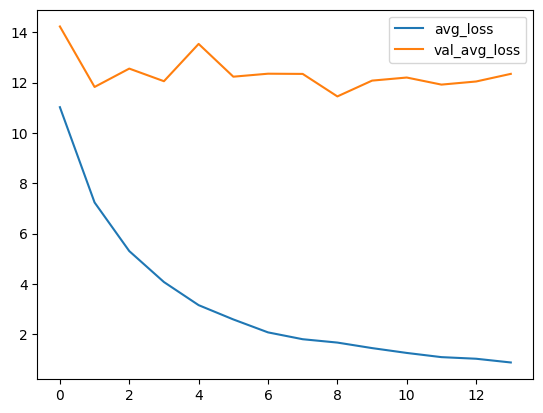

In [ ]:
plt.plot(hist.history['avg_loss'], label='avg_loss')
plt.plot(hist.history['val_avg_loss'], label='val_avg_loss')
plt.legend()

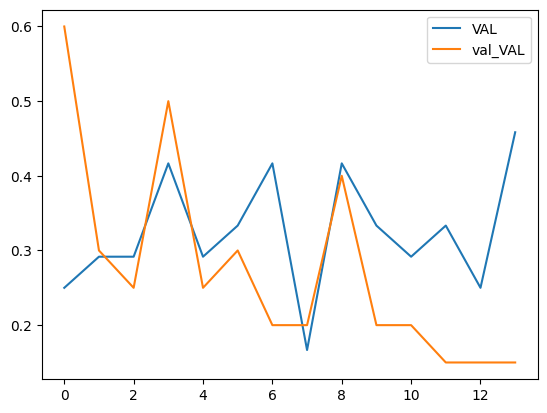

In [ ]:
plt.plot(hist.history['VAL'], label='VAL')
plt.plot(hist.history['val_VAL'], label='val_VAL')
plt.legend()

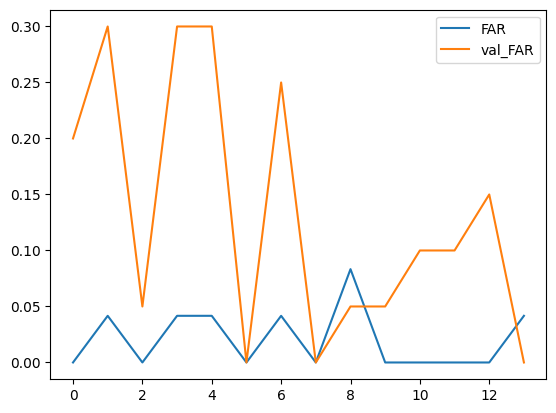

In [ ]:
plt.plot(hist.history['FAR'], label='FAR')
plt.plot(hist.history['val_FAR'], label='val_FAR')
plt.legend()

In [ ]:
similarity = np.empty((0, 2))
for batch in validation_data :
    d1, d2 = face_net_model.predict(batch)
    d1, d2 = d1.reshape(-1, 1), d2.reshape(-1, 1)
    hstacked = np.hstack((d1, d2))
    similarity = np.append(similarity,hstacked, axis=0)

1/1 [==============================] - 4s 4s/step


In [ ]:
display(similarity[:, 0].mean(), similarity[:, 1].mean())

1.6174223353862762

1.90653049492836

In [ ]:
threshold = face_net_model.threshold
threshold

<tf.Variable 'threshold:0' shape=() dtype=float32, numpy=1.1425434>

In [ ]:
embedding_model.input_shape

(None, 160, 160, 3)

In [ ]:
embedding_model.output_shape

(None, 128)

In [ ]:
batch[0].shape

TensorShape([20, 160, 160, 3])

In [ ]:
embedding_anchor = tf.squeeze(embedding_model(batch[0])) #anchors
embedding_positive = tf.squeeze(embedding_model(batch[1])) #positive
embedding_negative = tf.squeeze(embedding_model(batch[2])) #negative

In [ ]:
similarity = L2Similarity()
similarity = similarity (embedding_anchor, embedding_positive, embedding_negative)
similarity

(<tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([1.6233041 , 0.93062043, 1.6895167 , 2.0107207 , 1.7953485 ,
        0.6976117 , 1.2716165 , 1.7410133 , 1.3418928 , 1.9916863 ,
        1.7920932 , 1.2644616 , 0.77526665, 1.2259226 , 0.8778795 ,
        2.098813  , 2.4463835 , 2.1199117 , 1.5040765 , 1.9014055 ],
       dtype=float32)>,
 <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([1.4846224, 2.1952848, 1.9485803, 2.393267 , 1.7628   , 1.8108039,
        2.2940357, 2.0417576, 2.1825037, 2.038455 , 2.1665912, 2.8261905,
        0.8543583, 0.7872202, 2.3247824, 2.6461966, 2.5547953, 2.1563997,
        2.7287655, 2.2311976], dtype=float32)>)

In [ ]:
face_net_model.false_accept_rate(similarity[0], similarity[1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.1>

In [ ]:
!cp face_net_model.json /content/drive/MyDrive/Notebooks/FaceNet/face_net_model.json

In [ ]:
!cp face_net_model_weights.h5 /content/drive/MyDrive/Notebooks/FaceNet/face_net_model_weights.h5

In [ ]:
!cp -r model.tf/ /content/drive/MyDrive/Notebooks/FaceNet/model.tf